# Diagnostiliste monitoride haldusvahend
täida Exceli failis kaks töölehte:
* Inventar - millist monitori nägid millises ruumis mis kuupäeval ja millise arvuti küljes
<br> Tulbad: ['seeria nr.', 'med.teh. Nr.', 'tootja', 'mudel', 'asukoht', 'Esmane paigaldus', 'kontrolli kuupäev', 'Arvuti']
* Töötunnid - mis kuupäeval oli monitoril milline töötundude arv
<br> Tulbad: ['seeria nr.', 'kuupäev', 'Display runtime', 'backlight runtime'] 
<br>(Põhiline on 'backlight runtime' - kui on vaid üks number saadaval, siis see läheb siia tulpa)

Seosed luuaks monitoride seerianumbrite järgi - need peavad olema täpsed

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

#### Loeme sisse andmed Exceli failist

In [2]:
failinimi='diag.monitoride_haldus.xlsx'
inventar=pd.read_excel(failinimi, sheet_name='Inventar')
tootunnid=pd.read_excel(failinimi, sheet_name='Töötunnid')

#### Vaatame, mis Inventari töölehelt saime

In [3]:
#inventar.info()

In [4]:
# tabeli algus ja lõpp
pd.concat([inventar.head(2), inventar.tail(2)])

,seeria nr.,med.teh. Nr.,tootja,mudel,asukoht,Esmane paigaldus,kontrolli kuupäev,Arvuti
0,1890308661,008413,Barco,MDNC-3121,G1R178,NaT,2018-06-01,NaN
1,1890308659,008413,Barco,MDNC-3121,G1R178,NaT,2018-06-01,NaN
205,1890286330,008956,Barco,MDNC-3121,N106,2012-09-04,2018-10-01,RD168
206,1890286331,008957,Barco,MDNC-3121,N106,2012-09-04,2018-10-01,RD168


In [5]:
# võtame DataFrame'i indeksiks kuupäeva ja sorteerime DF'i selle järgi
inventar['Timepoint']=pd.to_datetime(inventar['kontrolli kuupäev'])
inventar.set_index('Timepoint', inplace=True)
inventar.sort_index(inplace=True)


In [6]:
pd.concat([inventar.head(2), inventar.tail(2)])

,seeria nr.,med.teh. Nr.,tootja,mudel,asukoht,Esmane paigaldus,kontrolli kuupäev,Arvuti
Timepoint,,,,,,,,
2013-12-13,20806063,RD199m,Eizo,S1923SH-BK,Riia167,2013-12-13,2013-12-13,NaN
2013-12-13,1890310337,009657,Barco,MDNC-3121,Riia167,2013-12-13,2013-12-13,NaN
2018-10-01,1890286330,008956,Barco,MDNC-3121,N106,2012-09-04,2018-10-01,RD168
2018-10-01,1890286331,008957,Barco,MDNC-3121,N106,2012-09-04,2018-10-01,RD168


#### Vaatame, mis Töötundide töölehelt saime

In [7]:
#tootunnid.info()

In [8]:
pd.concat([tootunnid.head(2), tootunnid.tail(2)])

,seeria nr.,kuupäev,Display runtime,backlight runtime
0,1890308661,2018-06-01 15:03:00,38598.0,5768
1,1890308659,2018-06-01 15:03:00,38597.0,5768
324,CX30SDKBS0004,2018-12-17 00:00:00,35711.0,4697
325,CX30SDKBS0002,2018-12-17 00:00:00,35710.0,4767


In [9]:
# võtame DataFrame'i indeksiks kuupäeva ja sorteerime DF'i selle järgi
tootunnid['Timepoint']=pd.to_datetime(tootunnid['kuupäev'])
tootunnid.set_index('Timepoint', inplace=True)
#tootunnid.set_index('seeria nr.', inplace=True)
tootunnid.sort_index(inplace=True)
# viskame ära vana kuupäeva veeru
tootunnid.drop('kuupäev', axis=1, inplace=True)
# esialgu viskame ära ka Display Runtime veeru
tootunnid.drop('Display runtime', axis=1, inplace=True)

In [10]:
pd.concat([tootunnid.head(2), tootunnid.tail(2)])

,seeria nr.,backlight runtime
Timepoint,,
2005-10-27,1890037868,10
2005-10-27,1890037846,10
2018-12-17,CX30SDKBS0004,4697
2018-12-17,CX30SDKBS0002,4767


In [11]:
# mitme erineva monitori kohta on andmeid töötundide tabelis?
len(tootunnid['seeria nr.'].unique().tolist())

91

### Loome kokkuvõtte monitoride hetkeseisust

Graafikute seaded

In [12]:
graafik_xmin=datetime.datetime(2010,1,1)
#graafik_xmin=tootunnid.groupby('seeria nr.').idxmin()['backlight runtime'].min()
graafik_xmax=datetime.datetime.now()+datetime.timedelta(3)
graafik_ymin=0
graafik_ymax=tootunnid['backlight runtime'].max()
graafik_ymax=35000
graafik_redline=25000
graafik_yline=tootunnid.groupby('seeria nr.')['backlight runtime'].max().mean()

In [13]:
# funktsioon iga monitori statistika väljastamiseks
def monstat():
    print('-----------')
    moninfo=inventar[inventar['seeria nr.']==monitor].tail(1).values.tolist()
    moninfo=moninfo[0]
    #moninfo[0] - serial nr
    el1=0
    for el in inventar.columns.tolist():
        print(el,':', moninfo[el1])
        el1+=1
    print()
    print('Töötundide tabel:')
    print(tootunnid[tootunnid['seeria nr.']==monitor])#['backlight runtime'])
    print('--')
    tootunnistatistika=tootunnid[tootunnid['seeria nr.']==monitor]['backlight runtime']
    if len(tootunnistatistika)>1:
        print('Kasutuskoormuse päevas=')
        a1=(tootunnistatistika[-1]-tootunnistatistika[-2])/(tootunnistatistika.index[-1]-tootunnistatistika.index[-2]).days
        a2=(tootunnistatistika[-1]-tootunnistatistika[0])/(tootunnistatistika.index[-1]-tootunnistatistika.index[0]).days
        print('Viimasel ajal:',"%.2f" % a1, 'tundi päevas')
        print('Kogu monitori kasutusajal: ',"%.2f" % a2,'tundi päevas')
    ax=tootunnid[tootunnid['seeria nr.']==monitor]['backlight runtime'].plot(title=(str(moninfo[2])+' '+str(moninfo[3])+' '+str(moninfo[0])), xlim=[graafik_xmin, graafik_xmax], ylim=[graafik_ymin, graafik_ymax], marker='o')
    ax.axhline(graafik_redline, color='red', linestyle='--', lw=1)
    ax.axhline(graafik_yline, color='y', linestyle='--', lw=0.5)
    plt.show()
    print('-------------')
    

In [14]:
#%matplotlib qt 
# näitab graafikut eraldi aknas
#%matplotlib inline 
# näitab graafikut töölehel

-----------
seeria nr. : CX30SDKBS0004
med.teh. Nr. : 010149
tootja : Wide
mudel : CX30
asukoht : G1R178
Esmane paigaldus : NaT
kontrolli kuupäev : 2018-06-01 00:00:00
Arvuti : RD222

Töötundide tabel:
                        seeria nr.  backlight runtime
Timepoint                                            
2014-11-20 00:00:00  CX30SDKBS0004                 10
2017-08-15 00:00:00  CX30SDKBS0004               2815
2018-06-01 15:16:00  CX30SDKBS0004               3908
2018-12-17 00:00:00  CX30SDKBS0004               4697
--
Kasutuskoormuse päevas=
Viimasel ajal: 3.98 tundi päevas
Kogu monitori kasutusajal:  3.15 tundi päevas


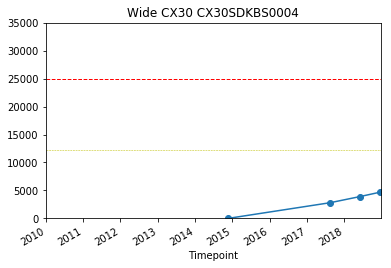

-------------


In [15]:
# testime funktsiooni
#monitor='CX30SDKBS0006'
#monitor='CX30SDKBS0010'
#monitor=28629057
monitor='CX30SDKBS0004'
monstat()
del monitor

### Vaja oleks lisada
* monitorid esitada järjekorras: ruumide järgi, arvutite järgi
* võtta arvesse vaid diagnostilised monitorid?
* tõsta esile rohkem töötanud monitorid
* tõsta esile suurema koormusega monitorid

In [16]:
#tootunnistatistika=tootunnid[tootunnid['seeria nr.']==1879012501]['backlight runtime']

In [17]:
#len(tootunnistatistika)

### Teeme nimekirja diagnostilistest monitoridest

In [18]:
mudelid=inventar['mudel'].unique().tolist()
for i in range(len(mudelid)):
    print(i,'-',inventar[inventar['mudel']==mudelid[i]]['tootja'][0], mudelid[i])

0 - Eizo S1923SH-BK
1 - Barco MDNC-3121
2 - Barco E-3620
3 - Barco E-2620
4 - Eizo L887
5 - Eizo S2000
6 - Wide CX30
7 - Eizo S1933
8 - Eizo FlexScan L887
9 - Barco MDCC-6130
10 - Barco E-2620 S
11 - Wide ZU30IDQ
12 - Barco MDMG-5221
13 - Barco MDRC-2221
14 - Eizo L885
15 - Eizo S1923
16 - Eizo FlexScan L885
17 - Eizo RX350
18 - Barco MDNG-5121 CB


### Diagnostiliste monitoride mudelid nendest on millised?
märgi sobilikud numbrid ülalt järgnevasse muutujasse

In [19]:
diagmudelid=[1,2,3,6,9,10,11,12,13,17,18]

### siin asendame listis numbrid mudelite nimetustega
diagmudelid2=[]
print('Diagnostilised mudelid: ')
for i in diagmudelid:
    diagmudelid2=diagmudelid2+[mudelid[i]]
    print(inventar[inventar['mudel']==mudelid[i]]['tootja'][0], mudelid[i])
diagmudelid=diagmudelid2
del diagmudelid2

Diagnostilised mudelid: 
Barco MDNC-3121
Barco E-3620
Barco E-2620
Wide CX30
Barco MDCC-6130
Barco E-2620 S
Wide ZU30IDQ
Barco MDMG-5221
Barco MDRC-2221
Eizo RX350
Barco MDNG-5121 CB


#### Järgnev lõik genereerib lühiraporti iga diagnostilise monitori kohta

-----------
seeria nr. : 1890037868
med.teh. Nr. : 18383
tootja : Barco
mudel : E-2620 S
asukoht : L6-C123
Esmane paigaldus : NaT
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD215

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2005-10-27  1890037868                 10
2017-08-10  1890037868              25878
2018-09-21  1890037868              26583
--
Kasutuskoormuse päevas=
Viimasel ajal: 1.73 tundi päevas
Kogu monitori kasutusajal:  5.64 tundi päevas


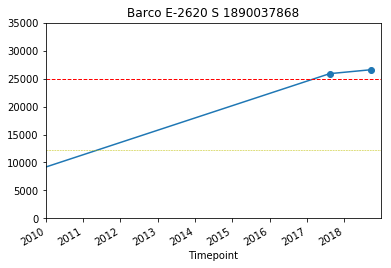

-------------
-----------
seeria nr. : 1890037846
med.teh. Nr. : 18383
tootja : Barco
mudel : E-2620 S
asukoht : L6-C123
Esmane paigaldus : NaT
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD215

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2005-10-27  1890037846                 10
2017-08-10  1890037846              25888
2018-09-21  1890037846              26592
--
Kasutuskoormuse päevas=
Viimasel ajal: 1.73 tundi päevas
Kogu monitori kasutusajal:  5.64 tundi päevas


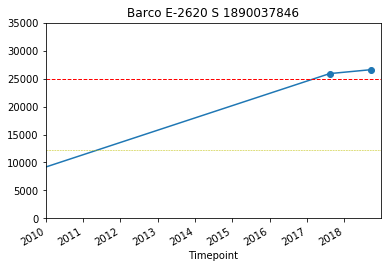

-------------
-----------
seeria nr. : 1890152714
med.teh. Nr. : 008054
tootja : Barco
mudel : MDCC-6130
asukoht : G1R181
Esmane paigaldus : 2009-06-01 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD239

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2009-06-01  1890152714                 10
2017-08-10  1890152714              13842
2018-09-21  1890152714              15370
--
Kasutuskoormuse päevas=
Viimasel ajal: 3.75 tundi päevas
Kogu monitori kasutusajal:  4.52 tundi päevas


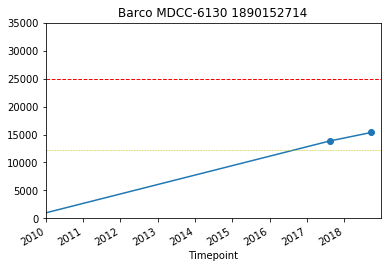

-------------
-----------
seeria nr. : 1890220526
med.teh. Nr. : 008014
tootja : Barco
mudel : MDNC-3121
asukoht : G1R178
Esmane paigaldus : 2010-12-21 00:00:00
kontrolli kuupäev : 2018-06-01 00:00:00
Arvuti : RD112

Töötundide tabel:
                     seeria nr.  backlight runtime
Timepoint                                         
2010-12-21 00:00:00  1890220526                 10
2017-08-15 00:00:00  1890220526              12665
2018-06-01 15:10:00  1890220526              14006
2018-09-25 00:00:00  1890220526              14370
--
Kasutuskoormuse päevas=
Viimasel ajal: 3.17 tundi päevas
Kogu monitori kasutusajal:  5.07 tundi päevas


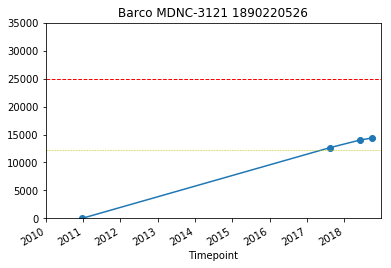

-------------
-----------
seeria nr. : 1890220533
med.teh. Nr. : 008013
tootja : Barco
mudel : MDNC-3121
asukoht : G1R178
Esmane paigaldus : NaT
kontrolli kuupäev : 2018-06-01 00:00:00
Arvuti : RD112

Töötundide tabel:
                     seeria nr.  backlight runtime
Timepoint                                         
2010-12-21 00:00:00  1890220533                 10
2017-08-15 00:00:00  1890220533              12665
2018-06-01 15:10:00  1890220533              14005
2018-09-25 00:00:00  1890220533              14369
--
Kasutuskoormuse päevas=
Viimasel ajal: 3.17 tundi päevas
Kogu monitori kasutusajal:  5.06 tundi päevas


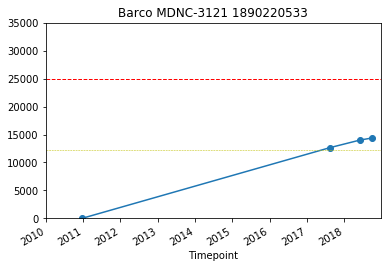

-------------
-----------
seeria nr. : 1890220257
med.teh. Nr. : 008016
tootja : Barco
mudel : MDNC-3121
asukoht : L6-C123
Esmane paigaldus : 2010-12-21 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD117

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2010-12-21  1890220257                 10
2017-08-11  1890220257              12593
2018-09-21  1890220257              14642
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.05 tundi päevas
Kogu monitori kasutusajal:  5.17 tundi päevas


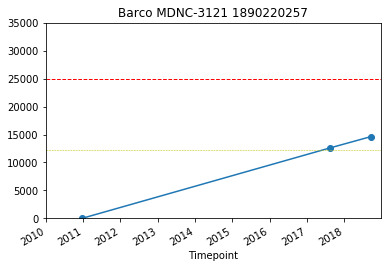

-------------
-----------
seeria nr. : 1890220265
med.teh. Nr. : 008015
tootja : Barco
mudel : MDNC-3121
asukoht : L6-C123
Esmane paigaldus : 2010-12-21 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD117

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2010-12-21  1890220265                 10
2017-08-11  1890220265              12596
2018-09-21  1890220265              14645
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.05 tundi päevas
Kogu monitori kasutusajal:  5.17 tundi päevas


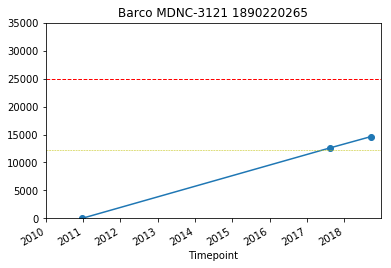

-------------
-----------
seeria nr. : 1890232754
med.teh. Nr. : 008033
tootja : Barco
mudel : MDCC-6130
asukoht : G1R177
Esmane paigaldus : 2011-09-13 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD142

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2011-09-13  1890232754                 10
2017-08-10  1890232754               8149
2018-09-21  1890232754               9834
--
Kasutuskoormuse päevas=
Viimasel ajal: 4.14 tundi päevas
Kogu monitori kasutusajal:  3.83 tundi päevas


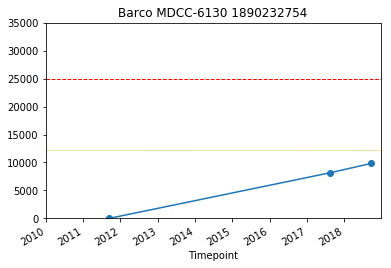

-------------
-----------
seeria nr. : 1890224030
med.teh. Nr. : 008032
tootja : Barco
mudel : MDCC-6130
asukoht : G1R152
Esmane paigaldus : 2011-09-15 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD144

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2011-09-13  1890224030                 10
2017-08-10  1890224030               9443
2018-09-21  1890224030              11453
--
Kasutuskoormuse päevas=
Viimasel ajal: 4.94 tundi päevas
Kogu monitori kasutusajal:  4.46 tundi päevas


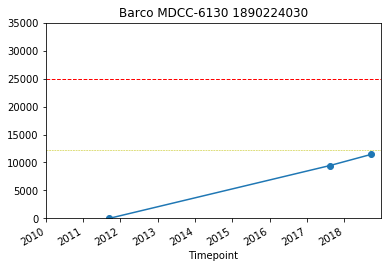

-------------
-----------
seeria nr. : 1890232747
med.teh. Nr. : 008034
tootja : Barco
mudel : MDCC-6130
asukoht : P1a-1156
Esmane paigaldus : 2011-09-19 00:00:00
kontrolli kuupäev : 2018-09-10 00:00:00
Arvuti : RD145

Töötundide tabel:
                     seeria nr.  backlight runtime
Timepoint                                         
2011-09-13 00:00:00  1890232747                 10
2017-08-11 00:00:00  1890232747               6385
2018-09-10 12:25:00  1890232747               7598
2018-09-25 00:00:00  1890232747               7663
--
Kasutuskoormuse päevas=
Viimasel ajal: 4.64 tundi päevas
Kogu monitori kasutusajal:  2.98 tundi päevas


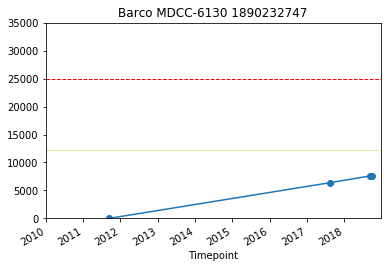

-------------
-----------
seeria nr. : 1890286255
med.teh. Nr. : 009227
tootja : Barco
mudel : MDNC-3121
asukoht : EMO
Esmane paigaldus : 2012-09-04 00:00:00
kontrolli kuupäev : 2018-02-14 00:00:00
Arvuti : nan

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2012-09-04  1890286255                 10
2017-08-10  1890286255              16605
--
Kasutuskoormuse päevas=
Viimasel ajal: 9.21 tundi päevas
Kogu monitori kasutusajal:  9.21 tundi päevas


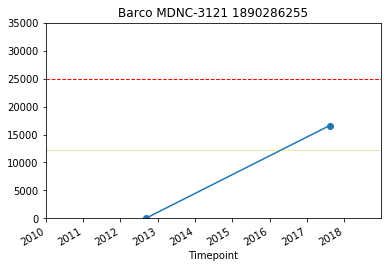

-------------
-----------
seeria nr. : 1890286451
med.teh. Nr. : 009228
tootja : Barco
mudel : MDNC-3121
asukoht : EMO
Esmane paigaldus : 2012-09-04 00:00:00
kontrolli kuupäev : 2018-02-14 00:00:00
Arvuti : nan

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2012-09-04  1890286451                 10
2017-08-10  1890286451              16605
--
Kasutuskoormuse päevas=
Viimasel ajal: 9.21 tundi päevas
Kogu monitori kasutusajal:  9.21 tundi päevas


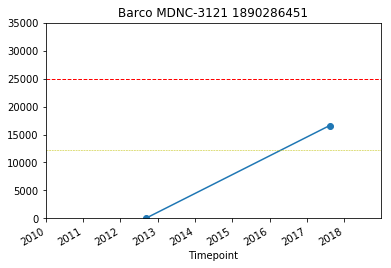

-------------
-----------
seeria nr. : 1890286330
med.teh. Nr. : 008956
tootja : Barco
mudel : MDNC-3121
asukoht : N106
Esmane paigaldus : 2012-09-04 00:00:00
kontrolli kuupäev : 2018-10-01 00:00:00
Arvuti : RD168

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2012-09-04  1890286330                 10
2018-10-01  1890286330              10644
--
Kasutuskoormuse päevas=
Viimasel ajal: 4.79 tundi päevas
Kogu monitori kasutusajal:  4.79 tundi päevas


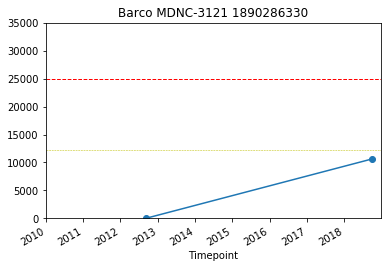

-------------
-----------
seeria nr. : 1890286331
med.teh. Nr. : 008957
tootja : Barco
mudel : MDNC-3121
asukoht : N106
Esmane paigaldus : 2012-09-04 00:00:00
kontrolli kuupäev : 2018-10-01 00:00:00
Arvuti : RD168

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2012-09-04  1890286331                 10
2018-10-01  1890286331              10645
--
Kasutuskoormuse päevas=
Viimasel ajal: 4.79 tundi päevas
Kogu monitori kasutusajal:  4.79 tundi päevas


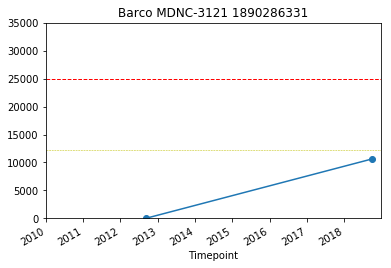

-------------
-----------
seeria nr. : 1890310337
med.teh. Nr. : 009657
tootja : Barco
mudel : MDNC-3121
asukoht : Riia167
Esmane paigaldus : 2013-12-13 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD190

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2013-12-13  1890310337                 10
2017-08-11  1890310337               9179
2018-09-21  1890310337              10804
--
Kasutuskoormuse päevas=
Viimasel ajal: 4.00 tundi päevas
Kogu monitori kasutusajal:  6.19 tundi päevas


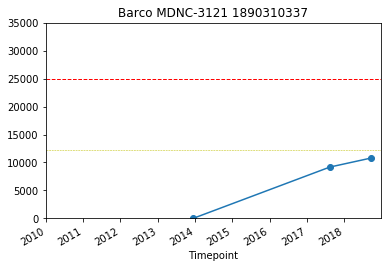

-------------
-----------
seeria nr. : 1890310338
med.teh. Nr. : 009657
tootja : Barco
mudel : MDNC-3121
asukoht : Riia167
Esmane paigaldus : 2013-12-13 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD190

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2013-12-13  1890310338                 10
2017-08-11  1890310338               9107
2018-09-21  1890310338              10733
--
Kasutuskoormuse päevas=
Viimasel ajal: 4.00 tundi päevas
Kogu monitori kasutusajal:  6.15 tundi päevas


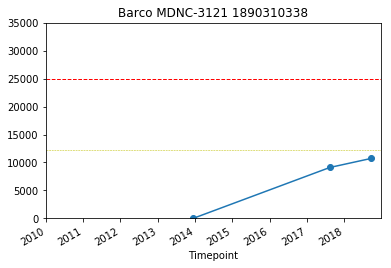

-------------
-----------
seeria nr. : 1890310332
med.teh. Nr. : 008415
tootja : Barco
mudel : MDNC-3121
asukoht : G1R177
Esmane paigaldus : 2013-12-19 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD191

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2013-12-19  1890310332                 24
2017-08-10  1890310332               6769
2018-09-21  1890310332               8872
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.17 tundi päevas
Kogu monitori kasutusajal:  5.09 tundi päevas


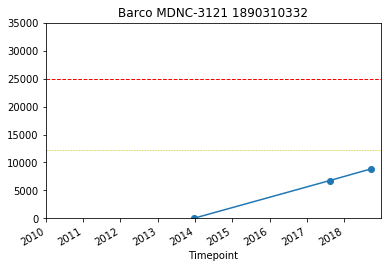

-------------
-----------
seeria nr. : 1890310334
med.teh. Nr. : 008415
tootja : Barco
mudel : MDNC-3121
asukoht : G1R177
Esmane paigaldus : 2013-12-19 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD191

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2013-12-19  1890310334                 23
2017-08-10  1890310334               6770
2018-09-21  1890310334               8873
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.17 tundi päevas
Kogu monitori kasutusajal:  5.09 tundi päevas


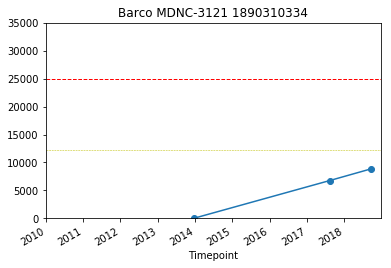

-------------
-----------
seeria nr. : 1879012886
med.teh. Nr. : nan
tootja : Barco
mudel : E-3620
asukoht : Laos
Esmane paigaldus : NaT
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : nan

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2013-12-19  1879012886              27573
--


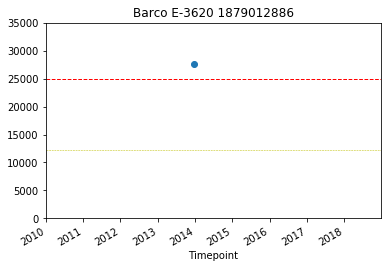

-------------
-----------
seeria nr. : 1879012501
med.teh. Nr. : nan
tootja : Barco
mudel : E-3620
asukoht : Laos
Esmane paigaldus : NaT
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : nan

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2013-12-19  1879012501              28010
--


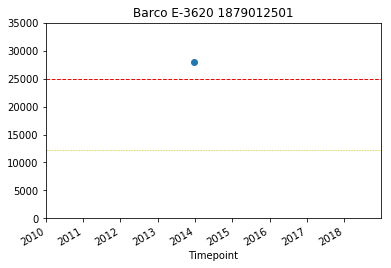

-------------
-----------
seeria nr. : 1890308347
med.teh. Nr. : 008411
tootja : Barco
mudel : MDNC-3121
asukoht : G1R167
Esmane paigaldus : 2013-12-20 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD192

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2013-12-20  1890308347                 39
2013-12-20  1890308347                 39
2017-08-10  1890308347              10351
2018-09-21  1890308347              12420
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.08 tundi päevas
Kogu monitori kasutusajal:  7.13 tundi päevas


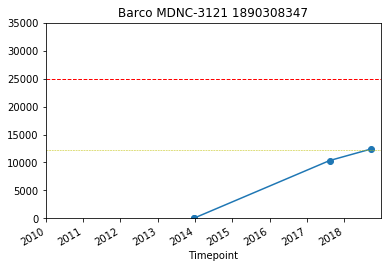

-------------
-----------
seeria nr. : 1890308425
med.teh. Nr. : 008411
tootja : Barco
mudel : MDNC-3121
asukoht : G1R167
Esmane paigaldus : 2013-12-20 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD192

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2013-12-20  1890308425                 39
2013-12-20  1890308425                 39
2017-08-10  1890308425              10343
2018-09-21  1890308425              12415
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.09 tundi päevas
Kogu monitori kasutusajal:  7.13 tundi päevas


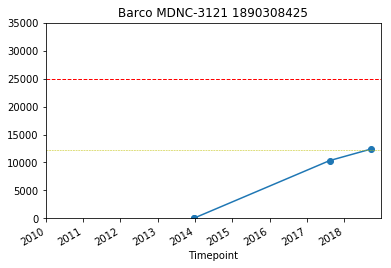

-------------
-----------
seeria nr. : 1890308659
med.teh. Nr. : 008413
tootja : Barco
mudel : MDNC-3121
asukoht : G1R178
Esmane paigaldus : 2014-01-08 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD189

Töötundide tabel:
                     seeria nr.  backlight runtime
Timepoint                                         
2014-01-08 00:00:00  1890308659                 92
2014-01-08 00:00:00  1890308659                 92
2017-08-10 00:00:00  1890308659               4729
2018-06-01 15:03:00  1890308659               5768
2018-09-21 00:00:00  1890308659               6250
--
Kasutuskoormuse päevas=
Viimasel ajal: 4.34 tundi päevas
Kogu monitori kasutusajal:  3.59 tundi päevas


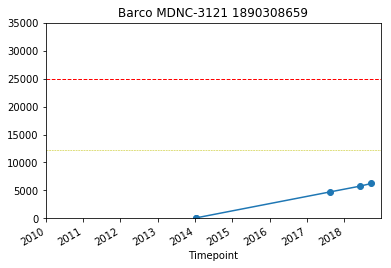

-------------
-----------
seeria nr. : 1890308661
med.teh. Nr. : 008413
tootja : Barco
mudel : MDNC-3121
asukoht : G1R178
Esmane paigaldus : 2014-01-08 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD189

Töötundide tabel:
                     seeria nr.  backlight runtime
Timepoint                                         
2014-01-08 00:00:00  1890308661                 92
2014-01-08 00:00:00  1890308661                 92
2017-08-10 00:00:00  1890308661               4728
2018-06-01 15:03:00  1890308661               5768
2018-09-21 00:00:00  1890308661               6249
--
Kasutuskoormuse päevas=
Viimasel ajal: 4.33 tundi päevas
Kogu monitori kasutusajal:  3.59 tundi päevas


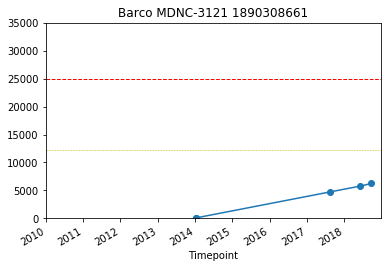

-------------
-----------
seeria nr. : 1890308771
med.teh. Nr. : 008412
tootja : Barco
mudel : MDNC-3121
asukoht : G1R167
Esmane paigaldus : 2014-01-10 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD187

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2014-01-10  1890308771                 51
2014-01-10  1890308771                 51
2017-08-10  1890308771               4826
2018-09-21  1890308771               6442
--
Kasutuskoormuse päevas=
Viimasel ajal: 3.97 tundi päevas
Kogu monitori kasutusajal:  3.73 tundi päevas


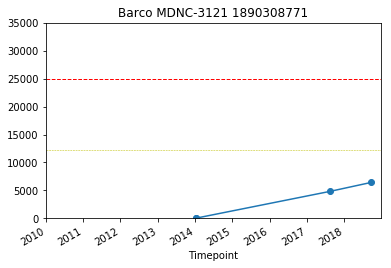

-------------
-----------
seeria nr. : 1890309331
med.teh. Nr. : 008412
tootja : Barco
mudel : MDNC-3121
asukoht : G1R167
Esmane paigaldus : 2014-01-10 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD187

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2014-01-10  1890309331                 45
2014-01-10  1890309331                 45
2017-08-10  1890309331               4821
2018-09-21  1890309331               6427
--
Kasutuskoormuse päevas=
Viimasel ajal: 3.95 tundi päevas
Kogu monitori kasutusajal:  3.72 tundi päevas


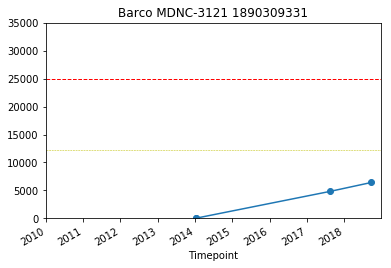

-------------
-----------
seeria nr. : 1890309257
med.teh. Nr. : 009656
tootja : Barco
mudel : MDNC-3121
asukoht : G1R137
Esmane paigaldus : 2014-02-17 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD188

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2014-02-17  1890309257                 24
2014-02-17  1890309257                 24
2017-08-09  1890309257               6093
2018-09-21  1890309257               8225
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.23 tundi päevas
Kogu monitori kasutusajal:  4.89 tundi päevas


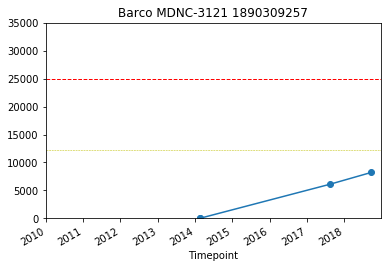

-------------
-----------
seeria nr. : 1890308774
med.teh. Nr. : 009656
tootja : Barco
mudel : MDNC-3121
asukoht : G1R137
Esmane paigaldus : 2014-02-17 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD188

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2014-02-17  1890308774                111
2014-02-17  1890308774                111
2017-08-09  1890308774               6124
2018-09-21  1890308774               8256
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.23 tundi päevas
Kogu monitori kasutusajal:  4.86 tundi päevas


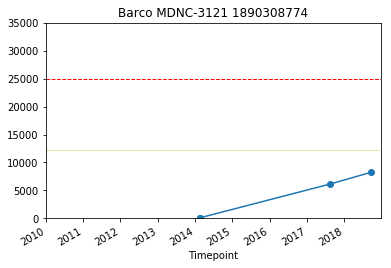

-------------
-----------
seeria nr. : 1890310536
med.teh. Nr. : 008414
tootja : Barco
mudel : MDNC-3121
asukoht : G1R127
Esmane paigaldus : 2014-02-18 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD193

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2014-02-18  1890310536                 22
2014-02-18  1890310536                 22
2017-08-09  1890310536              22856
2018-09-21  1890310536              26320
--
Kasutuskoormuse päevas=
Viimasel ajal: 8.49 tundi päevas
Kogu monitori kasutusajal:  15.69 tundi päevas


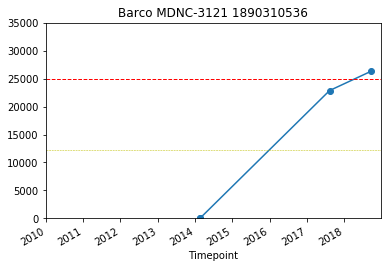

-------------
-----------
seeria nr. : 1890310562
med.teh. Nr. : 008414
tootja : Barco
mudel : MDNC-3121
asukoht : G1R127
Esmane paigaldus : 2014-02-18 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD193

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2014-02-18  1890310562                 39
2014-02-18  1890310562                 39
2017-08-09  1890310562              22876
2018-09-21  1890310562              26340
--
Kasutuskoormuse päevas=
Viimasel ajal: 8.49 tundi päevas
Kogu monitori kasutusajal:  15.69 tundi päevas


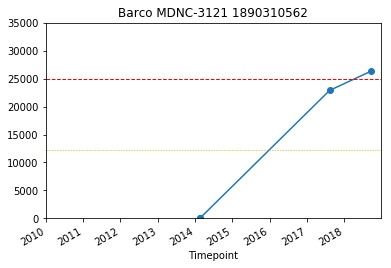

-------------
-----------
seeria nr. : 1879013265
med.teh. Nr. : 12318RD
tootja : Barco
mudel : E-3620
asukoht : L6-B306
Esmane paigaldus : NaT
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD237

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2014-02-27  1879013265              18460
2017-08-11  1879013265              26910
2018-09-21  1879013265              29248
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.76 tundi päevas
Kogu monitori kasutusajal:  6.47 tundi päevas


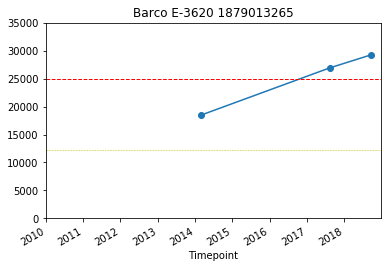

-------------
-----------
seeria nr. : 1879013261
med.teh. Nr. : 12319RD
tootja : Barco
mudel : E-3620
asukoht : L6-B306
Esmane paigaldus : NaT
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD237

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2014-02-27  1879013261              18455
2017-08-11  1879013261              28141
2018-09-21  1879013261              30475
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.75 tundi päevas
Kogu monitori kasutusajal:  7.21 tundi päevas


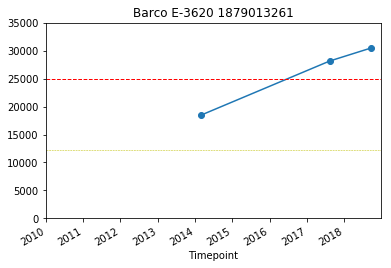

-------------
-----------
seeria nr. : 1890351250
med.teh. Nr. : nan
tootja : Barco
mudel : MDMG-5221
asukoht : G1R130
Esmane paigaldus : 2014-09-01 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD241

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2014-09-01  1890351250                 10
2017-08-10  1890351250               5616
2018-09-21  1890351250               8044
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.97 tundi päevas
Kogu monitori kasutusajal:  5.42 tundi päevas


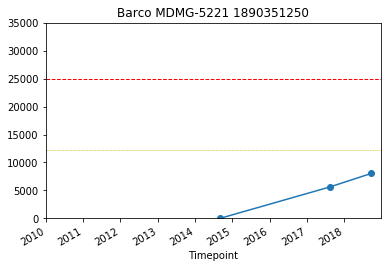

-------------
-----------
seeria nr. : 1890351139
med.teh. Nr. : nan
tootja : Barco
mudel : MDMG-5221
asukoht : G1R130
Esmane paigaldus : 2014-09-01 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD241

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2014-09-01  1890351139                 10
2017-08-10  1890351139               5588
2018-09-21  1890351139               8014
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.96 tundi päevas
Kogu monitori kasutusajal:  5.40 tundi päevas


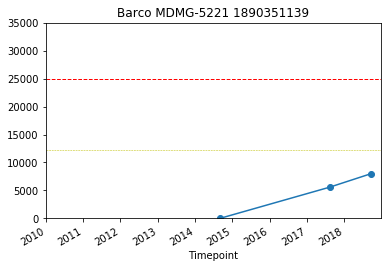

-------------
-----------
seeria nr. : 9384802007
med.teh. Nr. : nan
tootja : Barco
mudel : MDRC-2221
asukoht : G1R130
Esmane paigaldus : 2014-09-01 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD241

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2014-09-01  9384802007                 10
2017-08-10  9384802007               5457
2018-09-21  9384802007               7882
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.96 tundi päevas
Kogu monitori kasutusajal:  5.32 tundi päevas


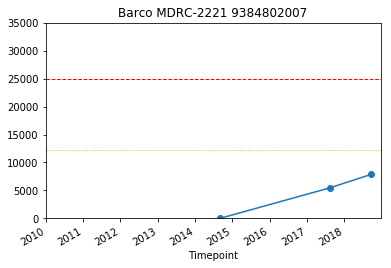

-------------
-----------
seeria nr. : CX30SDKBS0010
med.teh. Nr. : 010155
tootja : Wide
mudel : CX30
asukoht : G1R177
Esmane paigaldus : 2014-11-20 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD219

Töötundide tabel:
                        seeria nr.  backlight runtime
Timepoint                                            
2014-11-20 00:00:00  CX30SDKBS0010                 10
2017-08-10 00:00:00  CX30SDKBS0010               3934
2018-09-21 00:00:00  CX30SDKBS0010               8120
2018-09-24 00:00:00  CX30SDKBS0010               8195
2018-09-25 00:00:00  CX30SDKBS0010               8204
2018-09-27 10:30:00  CX30SDKBS0010               8212
2018-09-28 10:00:00  CX30SDKBS0010               8213
--
Kasutuskoormuse päevas=
Viimasel ajal: inf tundi päevas
Kogu monitori kasutusajal:  5.83 tundi päevas


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in longlong_scalars


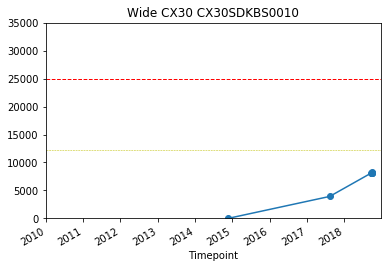

-------------
-----------
seeria nr. : CX30SDKBS0008
med.teh. Nr. : 010153
tootja : Wide
mudel : CX30
asukoht : G1R176
Esmane paigaldus : NaT
kontrolli kuupäev : 2018-09-11 00:00:00
Arvuti : RD223

Töötundide tabel:
               seeria nr.  backlight runtime
Timepoint                                   
2014-11-20  CX30SDKBS0008                 10
2017-08-09  CX30SDKBS0008               7122
2018-09-11  CX30SDKBS0008              11981
2018-09-25  CX30SDKBS0008              12132
--
Kasutuskoormuse päevas=
Viimasel ajal: 10.79 tundi päevas
Kogu monitori kasutusajal:  8.63 tundi päevas


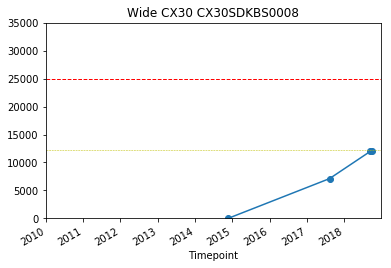

-------------
-----------
seeria nr. : CX30SDKBS0003
med.teh. Nr. : 010148
tootja : Wide
mudel : CX30
asukoht : G1R176
Esmane paigaldus : NaT
kontrolli kuupäev : 2018-09-11 00:00:00
Arvuti : RD223

Töötundide tabel:
               seeria nr.  backlight runtime
Timepoint                                   
2014-11-20  CX30SDKBS0003                 10
2017-08-09  CX30SDKBS0003               7121
2018-09-11  CX30SDKBS0003              11981
2018-09-25  CX30SDKBS0003              12132
--
Kasutuskoormuse päevas=
Viimasel ajal: 10.79 tundi päevas
Kogu monitori kasutusajal:  8.63 tundi päevas


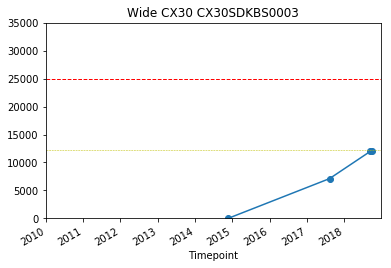

-------------
-----------
seeria nr. : CX30SDKBS0002
med.teh. Nr. : 010147
tootja : Wide
mudel : CX30
asukoht : G1R178
Esmane paigaldus : NaT
kontrolli kuupäev : 2018-06-01 00:00:00
Arvuti : RD222

Töötundide tabel:
                        seeria nr.  backlight runtime
Timepoint                                            
2014-11-20 00:00:00  CX30SDKBS0002                 10
2017-08-15 00:00:00  CX30SDKBS0002               2889
2018-06-01 15:16:00  CX30SDKBS0002               3982
2018-12-17 00:00:00  CX30SDKBS0002               4767
--
Kasutuskoormuse päevas=
Viimasel ajal: 3.96 tundi päevas
Kogu monitori kasutusajal:  3.20 tundi päevas


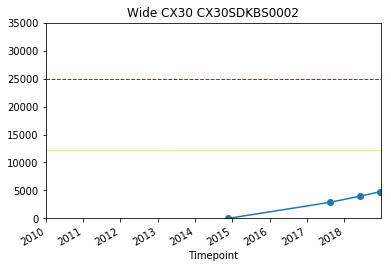

-------------
-----------
seeria nr. : CX30SDKBS0007
med.teh. Nr. : 010152
tootja : Wide
mudel : CX30
asukoht : G1R137
Esmane paigaldus : 2014-11-21 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD218

Töötundide tabel:
               seeria nr.  backlight runtime
Timepoint                                   
2014-11-20  CX30SDKBS0007                  1
2017-08-09  CX30SDKBS0007               3560
2018-09-21  CX30SDKBS0007               5353
--
Kasutuskoormuse päevas=
Viimasel ajal: 4.39 tundi päevas
Kogu monitori kasutusajal:  3.82 tundi päevas


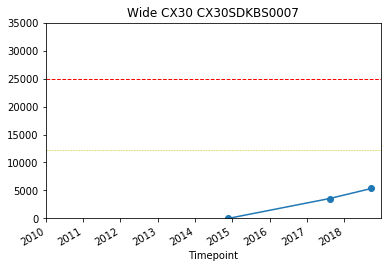

-------------
-----------
seeria nr. : CX30SDKBS0006
med.teh. Nr. : 010151
tootja : Wide
mudel : CX30
asukoht : G1R177
Esmane paigaldus : 2014-11-20 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD219

Töötundide tabel:
                        seeria nr.  backlight runtime
Timepoint                                            
2014-11-20 00:00:00  CX30SDKBS0006                 10
2017-08-10 00:00:00  CX30SDKBS0006               4001
2018-09-21 00:00:00  CX30SDKBS0006               8242
2018-09-24 00:00:00  CX30SDKBS0006               8317
2018-09-25 00:00:00  CX30SDKBS0006               8326
2018-09-27 10:30:00  CX30SDKBS0006               8334
2018-09-28 10:00:00  CX30SDKBS0006               8335
--
Kasutuskoormuse päevas=
Viimasel ajal: inf tundi päevas
Kogu monitori kasutusajal:  5.91 tundi päevas


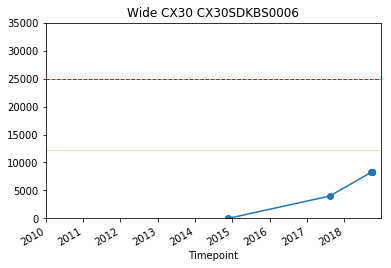

-------------
-----------
seeria nr. : CX30SDKBS0005
med.teh. Nr. : 010150
tootja : Wide
mudel : CX30
asukoht : G1R137
Esmane paigaldus : 2014-11-21 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD218

Töötundide tabel:
               seeria nr.  backlight runtime
Timepoint                                   
2014-11-20  CX30SDKBS0005                  1
2017-08-09  CX30SDKBS0005               3411
2018-09-21  CX30SDKBS0005               5194
--
Kasutuskoormuse päevas=
Viimasel ajal: 4.37 tundi päevas
Kogu monitori kasutusajal:  3.71 tundi päevas


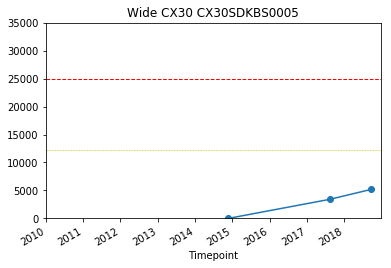

-------------
-----------
seeria nr. : CX30SDKBS0001
med.teh. Nr. : 010146
tootja : Wide
mudel : CX30
asukoht : P1a-1156
Esmane paigaldus : 2014-11-20 00:00:00
kontrolli kuupäev : 2018-09-10 00:00:00
Arvuti : RD220

Töötundide tabel:
                        seeria nr.  backlight runtime
Timepoint                                            
2014-11-20 00:00:00  CX30SDKBS0001                 10
2017-08-11 00:00:00  CX30SDKBS0001               6819
2018-09-10 12:25:00  CX30SDKBS0001               9395
2018-09-25 00:00:00  CX30SDKBS0001               9500
--
Kasutuskoormuse päevas=
Viimasel ajal: 7.50 tundi päevas
Kogu monitori kasutusajal:  6.75 tundi päevas


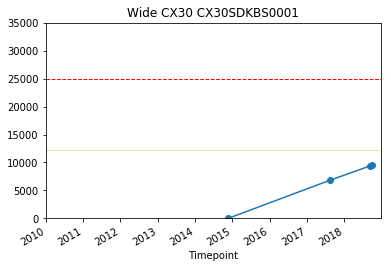

-------------
-----------
seeria nr. : CX30SDKBS0004
med.teh. Nr. : 010149
tootja : Wide
mudel : CX30
asukoht : G1R178
Esmane paigaldus : NaT
kontrolli kuupäev : 2018-06-01 00:00:00
Arvuti : RD222

Töötundide tabel:
                        seeria nr.  backlight runtime
Timepoint                                            
2014-11-20 00:00:00  CX30SDKBS0004                 10
2017-08-15 00:00:00  CX30SDKBS0004               2815
2018-06-01 15:16:00  CX30SDKBS0004               3908
2018-12-17 00:00:00  CX30SDKBS0004               4697
--
Kasutuskoormuse päevas=
Viimasel ajal: 3.98 tundi päevas
Kogu monitori kasutusajal:  3.15 tundi päevas


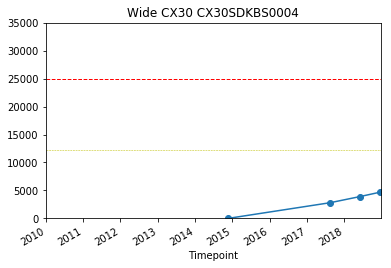

-------------
-----------
seeria nr. : ZU30ZDK9S0004
med.teh. Nr. : 010156
tootja : Wide
mudel : ZU30IDQ
asukoht : G1R130
Esmane paigaldus : 2014-11-20 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD221

Töötundide tabel:
               seeria nr.  backlight runtime
Timepoint                                   
2014-11-20  ZU30ZDK9S0004                  1
2017-08-10  ZU30ZDK9S0004               3359
2018-09-21  ZU30ZDK9S0004                 56
2018-09-24  ZU30ZDK9S0004                 64
--
Kasutuskoormuse päevas=
Viimasel ajal: 2.67 tundi päevas
Kogu monitori kasutusajal:  0.04 tundi päevas


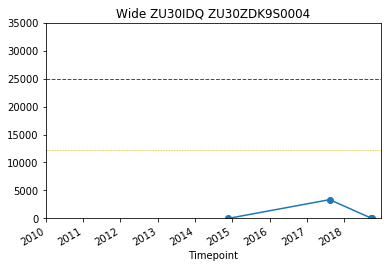

-------------
-----------
seeria nr. : CX30SDKBS0009
med.teh. Nr. : 010154
tootja : Wide
mudel : CX30
asukoht : P1a-1156
Esmane paigaldus : 2014-11-20 00:00:00
kontrolli kuupäev : 2018-09-10 00:00:00
Arvuti : RD220

Töötundide tabel:
                        seeria nr.  backlight runtime
Timepoint                                            
2014-11-20 00:00:00  CX30SDKBS0009                 10
2017-08-11 00:00:00  CX30SDKBS0009               6818
2018-09-10 12:25:00  CX30SDKBS0009               9401
2018-09-25 00:00:00  CX30SDKBS0009               9506
--
Kasutuskoormuse päevas=
Viimasel ajal: 7.50 tundi päevas
Kogu monitori kasutusajal:  6.76 tundi päevas


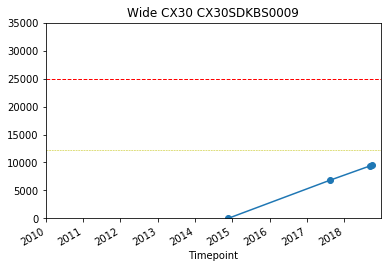

-------------
-----------
seeria nr. : 28508057
med.teh. Nr. : 011968
tootja : Eizo
mudel : RX350
asukoht : G1R176
Esmane paigaldus : 2017-12-22 00:00:00
kontrolli kuupäev : 2018-09-11 00:00:00
Arvuti : RD275

Töötundide tabel:
                    seeria nr.  backlight runtime
Timepoint                                        
2017-12-22 00:00:00   28508057                 10
2018-09-04 02:04:00   28508057               2008
2018-09-11 00:00:00   28508057               2016
2018-09-18 00:00:00   28508057               2097
2018-12-11 02:03:00   28508057               2774
--
Kasutuskoormuse päevas=
Viimasel ajal: 8.06 tundi päevas
Kogu monitori kasutusajal:  7.81 tundi päevas


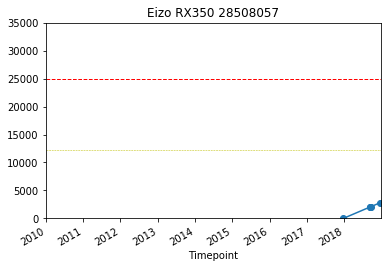

-------------
-----------
seeria nr. : 28509057
med.teh. Nr. : 011969
tootja : Eizo
mudel : RX350
asukoht : G1R176
Esmane paigaldus : 2017-12-22 00:00:00
kontrolli kuupäev : 2018-09-11 00:00:00
Arvuti : RD275

Töötundide tabel:
                    seeria nr.  backlight runtime
Timepoint                                        
2017-12-22 00:00:00   28509057                 10
2018-09-04 02:03:00   28509057               2000
2018-09-11 00:00:00   28509057               2008
2018-09-18 00:00:00   28509057               2088
2018-12-11 02:04:00   28509057               2763
--
Kasutuskoormuse päevas=
Viimasel ajal: 8.04 tundi päevas
Kogu monitori kasutusajal:  7.78 tundi päevas


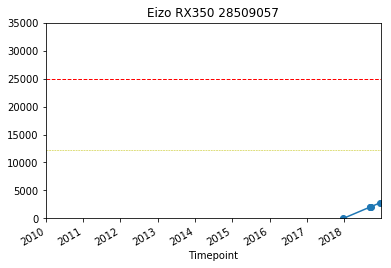

-------------
-----------
seeria nr. : 28442057
med.teh. Nr. : 011966
tootja : Eizo
mudel : RX350
asukoht : G1R152
Esmane paigaldus : 2017-12-22 00:00:00
kontrolli kuupäev : 2018-09-10 00:00:00
Arvuti : RD274

Töötundide tabel:
                    seeria nr.  backlight runtime
Timepoint                                        
2017-12-22 00:00:00   28442057                 10
2018-05-22 02:03:00   28442057                763
2018-09-10 11:18:00   28442057               1133
2018-09-24 00:00:00   28442057               1204
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.46 tundi päevas
Kogu monitori kasutusajal:  4.33 tundi päevas


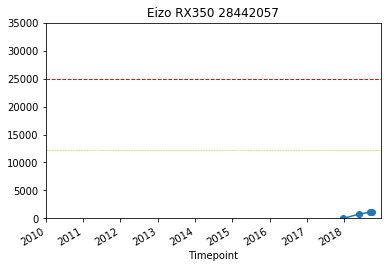

-------------
-----------
seeria nr. : 28610057
med.teh. Nr. : 0011973
tootja : Eizo
mudel : RX350
asukoht : G1R175
Esmane paigaldus : 2017-12-22 00:00:00
kontrolli kuupäev : 2018-09-10 00:00:00
Arvuti : RD277

Töötundide tabel:
                    seeria nr.  backlight runtime
Timepoint                                        
2017-12-22 00:00:00   28610057                 10
2018-09-04 02:03:00   28610057               2567
2018-09-18 00:00:00   28610057               2679
2018-09-24 00:00:00   28610057               2714
2018-12-11 02:03:00   28610057               3552
--
Kasutuskoormuse päevas=
Viimasel ajal: 10.74 tundi päevas
Kogu monitori kasutusajal:  10.01 tundi päevas


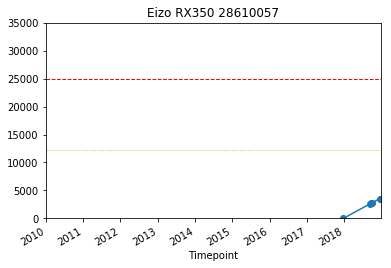

-------------
-----------
seeria nr. : 28530057
med.teh. Nr. : 0011972
tootja : Eizo
mudel : RX350
asukoht : G1R175
Esmane paigaldus : 2017-12-22 00:00:00
kontrolli kuupäev : 2018-09-10 00:00:00
Arvuti : RD277

Töötundide tabel:
                    seeria nr.  backlight runtime
Timepoint                                        
2017-12-22 00:00:00   28530057                 10
2018-09-04 02:03:00   28530057               2571
2018-09-18 00:00:00   28530057               2683
2018-09-24 00:00:00   28530057               2717
2018-12-11 02:03:00   28530057               3554
--
Kasutuskoormuse päevas=
Viimasel ajal: 10.73 tundi päevas
Kogu monitori kasutusajal:  10.01 tundi päevas


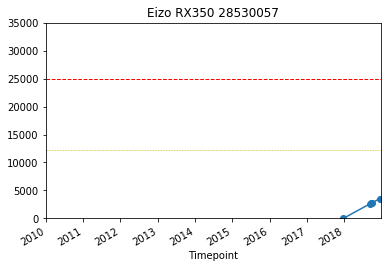

-------------
-----------
seeria nr. : 28525057
med.teh. Nr. : 011971
tootja : Eizo
mudel : RX350
asukoht : G1R175
Esmane paigaldus : 2017-12-22 00:00:00
kontrolli kuupäev : 2018-09-11 00:00:00
Arvuti : RD276

Töötundide tabel:
                    seeria nr.  backlight runtime
Timepoint                                        
2017-12-22 00:00:00   28525057                 10
2018-09-04 02:02:00   28525057               2747
2018-09-11 00:00:00   28525057               2759
2018-09-18 00:00:00   28525057               2856
2018-09-25 00:00:00   28525057               2931
2018-12-11 08:57:00   28525057               3696
--
Kasutuskoormuse päevas=
Viimasel ajal: 9.94 tundi päevas
Kogu monitori kasutusajal:  10.41 tundi päevas


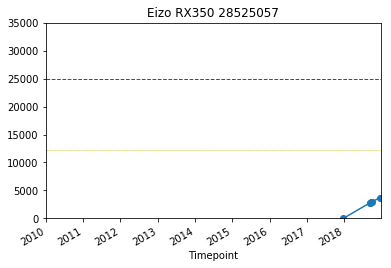

-------------
-----------
seeria nr. : 28511057
med.teh. Nr. : 011970
tootja : Eizo
mudel : RX350
asukoht : G1R175
Esmane paigaldus : 2017-12-22 00:00:00
kontrolli kuupäev : 2018-09-11 00:00:00
Arvuti : RD276

Töötundide tabel:
                    seeria nr.  backlight runtime
Timepoint                                        
2017-12-22 00:00:00   28511057                 10
2018-09-04 02:03:00   28511057               2736
2018-09-11 00:00:00   28511057               2748
2018-09-18 00:00:00   28511057               2845
2018-09-25 00:00:00   28511057               2921
2018-12-11 08:57:00   28511057               3682
--
Kasutuskoormuse päevas=
Viimasel ajal: 9.88 tundi päevas
Kogu monitori kasutusajal:  10.37 tundi päevas


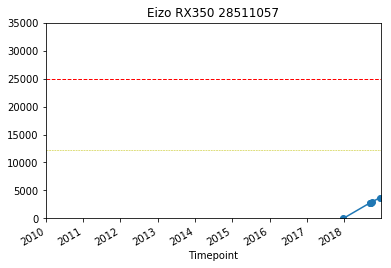

-------------
-----------
seeria nr. : 28623057
med.teh. Nr. : 011974
tootja : Eizo
mudel : RX350
asukoht : G1R175
Esmane paigaldus : 2017-12-22 00:00:00
kontrolli kuupäev : 2018-09-11 00:00:00
Arvuti : RD278

Töötundide tabel:
                    seeria nr.  backlight runtime
Timepoint                                        
2017-12-22 00:00:00   28623057                 10
2018-09-04 02:03:00   28623057               3721
2018-09-11 00:00:00   28623057               3740
2018-09-18 00:00:00   28623057               3869
2018-09-25 00:00:00   28623057               3955
2018-12-11 02:04:00   28623057               5241
--
Kasutuskoormuse päevas=
Viimasel ajal: 16.70 tundi päevas
Kogu monitori kasutusajal:  14.78 tundi päevas


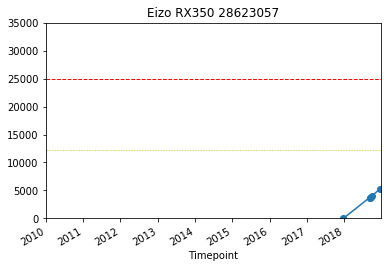

-------------
-----------
seeria nr. : 28629057
med.teh. Nr. : 011975
tootja : Eizo
mudel : RX350
asukoht : G1R175
Esmane paigaldus : 2017-12-22 00:00:00
kontrolli kuupäev : 2018-09-11 00:00:00
Arvuti : RD278

Töötundide tabel:
                    seeria nr.  backlight runtime
Timepoint                                        
2017-12-22 00:00:00   28629057                 10
2018-09-04 02:03:00   28629057               3706
2018-09-11 00:00:00   28629057               3725
2018-09-18 00:00:00   28629057               3854
2018-09-25 00:00:00   28629057               3939
2018-12-11 02:04:00   28629057               5220
--
Kasutuskoormuse päevas=
Viimasel ajal: 16.64 tundi päevas
Kogu monitori kasutusajal:  14.72 tundi päevas


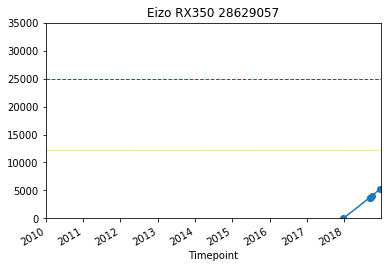

-------------
-----------
seeria nr. : 28473057
med.teh. Nr. : 011967
tootja : Eizo
mudel : RX350
asukoht : G1R152
Esmane paigaldus : 2017-12-22 00:00:00
kontrolli kuupäev : 2018-09-10 00:00:00
Arvuti : RD274

Töötundide tabel:
                        seeria nr.  backlight runtime
Timepoint                                            
2017-12-22 00:00:00.000   28473057                 10
2018-05-22 02:03:00.000   28473057                763
2018-09-11 11:17:59.995   28473057               1132
2018-09-24 00:00:00.000   28473057               1203
--
Kasutuskoormuse päevas=
Viimasel ajal: 5.92 tundi päevas
Kogu monitori kasutusajal:  4.32 tundi päevas


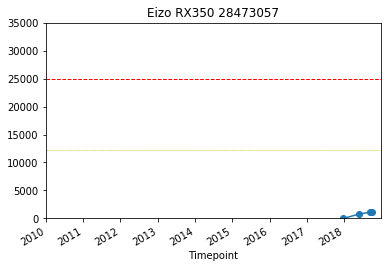

-------------
-----------
seeria nr. : 1879048622
med.teh. Nr. : 008011
tootja : Barco
mudel : MDNG-5121 CB
asukoht : G1R130
Esmane paigaldus : 2010-11-04 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD114

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2018-09-21  1879048622               3131
--


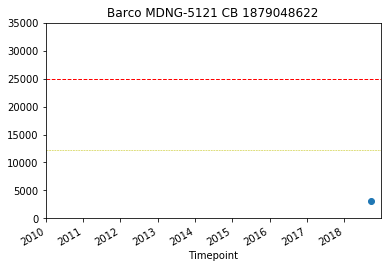

-------------
-----------
seeria nr. : 1879048625
med.teh. Nr. : 008012
tootja : Barco
mudel : MDNG-5121 CB
asukoht : G1R130
Esmane paigaldus : 2010-11-04 00:00:00
kontrolli kuupäev : 2018-09-21 00:00:00
Arvuti : RD114

Töötundide tabel:
            seeria nr.  backlight runtime
Timepoint                                
2018-09-21  1879048625               4878
--


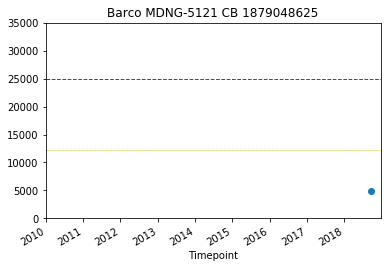

-------------
Wall time: 8.68 s


In [20]:
%%time
for monitor in tootunnid['seeria nr.'].unique().tolist():
    if inventar[inventar['seeria nr.']==monitor]['mudel'][0] in diagmudelid: # valib välja vaid diagnostilised monitorid mudeli nimetuse järgi
        monstat()

# Milliseid monitore pole ammu kontrollitud?

In [21]:
# Prooviks siis nii, et võtame inventari listist viimased kirjed ja liidame siia juurde viimase kontakti

In [22]:
inventar.sort_index(inplace=True)
inventar.head()

,seeria nr.,med.teh. Nr.,tootja,mudel,asukoht,Esmane paigaldus,kontrolli kuupäev,Arvuti
Timepoint,,,,,,,,
2013-12-13,20806063,RD199m,Eizo,S1923SH-BK,Riia167,2013-12-13,2013-12-13,NaN
2013-12-13,1890310337,009657,Barco,MDNC-3121,Riia167,2013-12-13,2013-12-13,NaN
2013-12-13,20951063,RD198m,Eizo,S1923SH-BK,Riia167,2013-12-13,2013-12-13,NaN
2013-12-13,1890310338,009657,Barco,MDNC-3121,Riia167,2013-12-13,2013-12-13,NaN
2013-12-19,1879012501,NaN,Barco,E-3620,G1R177,NaT,2013-12-19,NaN


In [23]:
viimati=inventar.groupby('seeria nr.').last()
viimati.head()

,med.teh. Nr.,tootja,mudel,asukoht,Esmane paigaldus,kontrolli kuupäev,Arvuti
seeria nr.,,,,,,,
20377063,RD207m,Eizo,S1923SH-BK,G1R127,2014-02-18,2018-09-21,RD193
20387063,RD196m,Eizo,S1923SH-BK,G1R178,2014-01-08,2018-09-21,RD189
20491063,RD202m,Eizo,S1923SH-BK,G1R177,2013-12-19,2018-09-21,RD191
20801063,RD206m,Eizo,S1923SH-BK,G1R137,2014-02-17,2018-09-21,RD188
20806063,RD199m,Eizo,S1923SH-BK,Riia167,2013-12-13,2018-09-21,RD190


In [24]:
# kopeerime Töötunni tabelis indeksi ka eraldi tulpa, et pärast gruppeerimist seda veel kasutada saaks
tootunnid['date']=tootunnid.index
tootunnid.sort_index(inplace=True)

#### Tabel kõige kauem kontrollimata monitoridest
ruumide ja arvutite kaupa grupeeritud

In [25]:
kontrollimata=pd.concat([viimati,tootunnid.groupby('seeria nr.').last()],axis=1, sort=False).sort_values('Arvuti').sort_values('asukoht').sort_values('date')[:60]

In [26]:
# näitame esimesed 40 kirjet
kontrollimata[:40]

,med.teh. Nr.,tootja,mudel,asukoht,Esmane paigaldus,kontrolli kuupäev,Arvuti,backlight runtime,date
1879012886,NaN,Barco,E-3620,Laos,NaT,2018-09-21,NaN,27573.0,2013-12-19 00:00:00
1879012501,NaN,Barco,E-3620,Laos,NaT,2018-09-21,NaN,28010.0,2013-12-19 00:00:00
1890286451,009228,Barco,MDNC-3121,EMO,2012-09-04,2018-02-14,NaN,16605.0,2017-08-10 00:00:00
1890286255,009227,Barco,MDNC-3121,EMO,2012-09-04,2018-02-14,NaN,16605.0,2017-08-10 00:00:00
22913014,RD235m,Eizo,S1933,G1R178,2014-11-20,2018-06-01,RD222,3588.0,2018-06-01 15:16:00
22047014,RD229m,Eizo,S1933,G1R178,2014-11-20,2018-06-01,RD222,3587.0,2018-06-01 15:16:00
21971014,RD228m,Eizo,S1933,P1a-1156,2014-11-20,2018-09-10,RD220,9201.0,2018-09-10 12:25:00
21908014,RD224m,Eizo,S1933,P1a-1156,2014-11-20,2018-09-10,RD220,9201.0,2018-09-10 12:25:00
20387063,RD196m,Eizo,S1923SH-BK,G1R178,2014-01-08,2018-09-21,RD189,6121.0,2018-09-21 00:00:00
1890232754,008033,Barco,MDCC-6130,G1R177,2011-09-13,2018-09-21,RD142,9834.0,2018-09-21 00:00:00


In [27]:
# soovi korral kirjutame otse excelisse
#datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S %f')
failinimi=datetime.datetime.now().strftime('%Y-%m-%d-kontrolli-vajavad-%f.xlsx')
kontrollimata.to_excel(failinimi)
del failinimi

***
## Genereerime raportid

## Teeme koondtabeli monitoridest
sortida ruumide kaupa ja seal all arvutite kaupa
esitada monitori põhiandmed
* ruum
* arvuti
* mon. tootja
* mon. mudel
* med teh nr?
* soetuse aeg
* töötunde
* kasutusaktiivsus viimati
* kasutusaktiivsus kogu ajalugu
tabelisse ainult diagnostilised monitorid

In [28]:
monitorid=pd.concat([viimati,tootunnid.groupby('seeria nr.').last()],axis=1, sort=False).sort_values('Arvuti').sort_values('asukoht')

In [29]:
monitorid.index.name='Serial'

In [30]:
monitorid.head()

,med.teh. Nr.,tootja,mudel,asukoht,Esmane paigaldus,kontrolli kuupäev,Arvuti,backlight runtime,date
Serial,,,,,,,,,
1890286451,009228,Barco,MDNC-3121,EMO,2012-09-04,2018-02-14,NaN,16605.0,2017-08-10
1890286255,009227,Barco,MDNC-3121,EMO,2012-09-04,2018-02-14,NaN,16605.0,2017-08-10
22485063,RD205m,Eizo,S1923SH-BK,G1R127,2014-02-18,2018-09-21,RD193,26291.0,2018-09-21
1890310562,008414,Barco,MDNC-3121,G1R127,2014-02-18,2018-09-21,RD193,26340.0,2018-09-21
1890310536,008414,Barco,MDNC-3121,G1R127,2014-02-18,2018-09-21,RD193,26320.0,2018-09-21


In [31]:
# jätame välja kõik mitte-diagnostilised monitorid
monitorid=monitorid[monitorid['mudel'].isin(diagmudelid)]

In [32]:
monitorid.head()

,med.teh. Nr.,tootja,mudel,asukoht,Esmane paigaldus,kontrolli kuupäev,Arvuti,backlight runtime,date
Serial,,,,,,,,,
1890286451,009228,Barco,MDNC-3121,EMO,2012-09-04,2018-02-14,NaN,16605.0,2017-08-10
1890286255,009227,Barco,MDNC-3121,EMO,2012-09-04,2018-02-14,NaN,16605.0,2017-08-10
1890310562,008414,Barco,MDNC-3121,G1R127,2014-02-18,2018-09-21,RD193,26340.0,2018-09-21
1890310536,008414,Barco,MDNC-3121,G1R127,2014-02-18,2018-09-21,RD193,26320.0,2018-09-21
ZU30ZDK9S0004,010156,Wide,ZU30IDQ,G1R130,2014-11-20,2018-09-21,RD221,64.0,2018-09-24


#### Monitori elueaks valime siin 30000 töötundi. Vajadusel muuda valemis

In [33]:
monitorid['Eluiga %']=monitorid['backlight runtime']/30000*100

#### Leiame iga monitori kasutuskoormuse
* viimaste kasutusandmete järgi
* kogu monitori jälgimise aja järgi

In [34]:
stat=pd.DataFrame(columns=['Viimane [h/24h]','Kogu [h/24h]'])
stat.index.name='Serial'

In [35]:
for mon in monitorid.index.tolist():
#    print(mon)
    tootunnistatistika=tootunnid[tootunnid['seeria nr.']==mon]['backlight runtime']
#    print(tootunnistatistika)
    if len(tootunnistatistika)==0: #kui ei ole töötunnistatistikas kirjeid monitori kohta
        a1=np.nan
        a2=np.nan
    elif len(tootunnistatistika)>1: # kui on mitu kirjet, et saaks arvutada kasutusaktiivsust
        a1=(tootunnistatistika[-1]-tootunnistatistika[-2])/(tootunnistatistika.index[-1]-tootunnistatistika.index[-2]).days
        a2=(tootunnistatistika[-1]-tootunnistatistika[0])/(tootunnistatistika.index[-1]-tootunnistatistika.index[0]).days
#    else: # kui on vaid 1 kirje statistika hulgas, oleks vaja arvutada kasutusaktiivsus a1 ja a2 nii, et soetusajaks arvestatakse töötunnid väärtusega 0
#        a1=(tootunnistatistika[-1]-tootunnistatistika[0])/(tootunnistatistika.index[-1]-tootunnistatistika.index[0]).days
    
#    print('Viimasel ajal:',"%.2f" % a1, 'tundi päevas')
#    print('Kogu monitori kasutusajal: ',"%.2f" % a2,'tundi päevas')
    stat.loc[mon]=pd.Series({'Viimane [h/24h]':a1, 'Kogu [h/24h]':a2})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in longlong_scalars
  if __name__ == '__main__':


In [36]:

monitorid=pd.concat([monitorid,stat], axis=1)

In [37]:
monitorid.head()

,med.teh. Nr.,tootja,mudel,asukoht,Esmane paigaldus,kontrolli kuupäev,Arvuti,backlight runtime,date,Eluiga %,Viimane [h/24h],Kogu [h/24h]
Serial,,,,,,,,,,,,
1890286451,009228,Barco,MDNC-3121,EMO,2012-09-04,2018-02-14,NaN,16605.0,2017-08-10,55.350000,9.214325,9.214325
1890286255,009227,Barco,MDNC-3121,EMO,2012-09-04,2018-02-14,NaN,16605.0,2017-08-10,55.350000,9.214325,9.214325
1890310562,008414,Barco,MDNC-3121,G1R127,2014-02-18,2018-09-21,RD193,26340.0,2018-09-21,87.800000,8.490196,15.692721
1890310536,008414,Barco,MDNC-3121,G1R127,2014-02-18,2018-09-21,RD193,26320.0,2018-09-21,87.733333,8.490196,15.690931
ZU30ZDK9S0004,010156,Wide,ZU30IDQ,G1R130,2014-11-20,2018-09-21,RD221,64.0,2018-09-24,0.213333,2.666667,0.044872


In [38]:
#viskame ära ebavajalikud tulbad
monitorid.drop('kontrolli kuupäev', axis=1, inplace=True)
# muudame tulpade nimesid
monitorid.rename(columns={'date':'viimane kontroll','backlight runtime':'Taustavalguse töötunde'}, inplace=True)

In [39]:
# väljastame Excelisse
failinimi=datetime.datetime.now().strftime('%Y-%m-%d-Raport.xlsx')
monitorid.to_excel(failinimi)

#### Seda faili peaks nüüd Excelis vormindama visuaalselt korrektsemaks...

### ---

### Leiame, millised monitorid on kõige rohkem kasutatud viimasel ajal

In [40]:
# kõige aktiivsemalt kasutuses
monitorid.sort_values('Viimane [h/24h]', ascending=False)[:10]

,med.teh. Nr.,tootja,mudel,asukoht,Esmane paigaldus,Arvuti,Taustavalguse töötunde,viimane kontroll,Eluiga %,Viimane [h/24h],Kogu [h/24h]
Serial,,,,,,,,,,,
CX30SDKBS0006,010151,Wide,CX30,G1R177,2014-11-20,RD219,8335.0,2018-09-28 10:00:00,27.783333,inf,5.912642
CX30SDKBS0010,010155,Wide,CX30,G1R177,2014-11-20,RD219,8213.0,2018-09-28 10:00:00,27.376667,inf,5.825994
28623057,011974,Eizo,RX350,G1R175,2017-12-22,RD278,5241.0,2018-12-11 02:04:00,17.470000,16.701299,14.776836
28629057,011975,Eizo,RX350,G1R175,2017-12-22,RD278,5220.0,2018-12-11 02:04:00,17.400000,16.636364,14.717514
CX30SDKBS0008,010153,Wide,CX30,G1R176,2014-11-20,RD223,12132.0,2018-09-25 00:00:00,40.440000,10.785714,8.627758
CX30SDKBS0003,010148,Wide,CX30,G1R176,2014-11-20,RD223,12132.0,2018-09-25 00:00:00,40.440000,10.785714,8.627758
28610057,0011973,Eizo,RX350,G1R175,2017-12-22,RD277,3552.0,2018-12-11 02:03:00,11.840000,10.743590,10.005650
28530057,0011972,Eizo,RX350,G1R175,2017-12-22,RD277,3554.0,2018-12-11 02:03:00,11.846667,10.730769,10.011299
28525057,011971,Eizo,RX350,G1R175,2017-12-22,RD276,3696.0,2018-12-11 08:57:00,12.320000,9.935065,10.412429


In [41]:
# Kõige aktiivsemalt kasutavad arvutid
arvutid=monitorid.sort_values('Viimane [h/24h]', ascending=False)[:16]['Arvuti'].unique()
monitorid[monitorid['Arvuti'].isin(arvutid)][['asukoht','Arvuti','Viimane [h/24h]']].groupby('Arvuti').last().sort_values('asukoht')

,asukoht,Viimane [h/24h]
Arvuti,,
RD193,G1R127,8.490196
RD276,G1R175,9.935065
RD277,G1R175,10.730769
RD278,G1R175,16.636364
RD223,G1R176,10.785714
RD275,G1R176,8.059524
RD219,G1R177,inf


In [42]:
# kõige rohkem töötunde
monitorid.sort_values('Taustavalguse töötunde', ascending=False)[:15]

,med.teh. Nr.,tootja,mudel,asukoht,Esmane paigaldus,Arvuti,Taustavalguse töötunde,viimane kontroll,Eluiga %,Viimane [h/24h],Kogu [h/24h]
Serial,,,,,,,,,,,
1879013261,12319RD,Barco,E-3620,L6-B306,NaT,RD237,30475.0,2018-09-21,101.583333,5.748768,7.210558
1879013265,12318RD,Barco,E-3620,L6-B306,NaT,RD237,29248.0,2018-09-21,97.493333,5.758621,6.471506
1879012501,NaN,Barco,E-3620,Laos,NaT,NaN,28010.0,2013-12-19,93.366667,1.729730,5.641341
1879012886,NaN,Barco,E-3620,Laos,NaT,NaN,27573.0,2013-12-19,91.910000,1.729730,5.641341
1890037846,18383,Barco,E-2620 S,L6-C123,NaT,RD215,26592.0,2018-09-21,88.640000,1.729730,5.641341
1890037868,18383,Barco,E-2620 S,L6-C123,NaT,RD215,26583.0,2018-09-21,88.610000,1.732187,5.639431
1890310562,008414,Barco,MDNC-3121,G1R127,2014-02-18,RD193,26340.0,2018-09-21,87.800000,8.490196,15.692721
1890310536,008414,Barco,MDNC-3121,G1R127,2014-02-18,RD193,26320.0,2018-09-21,87.733333,8.490196,15.690931
1890286451,009228,Barco,MDNC-3121,EMO,2012-09-04,NaN,16605.0,2017-08-10,55.350000,9.214325,9.214325


***
## Kvaliteedikontroll

In [43]:
# kvaliteedi kontroll

In [44]:
seriaal=28442057

In [45]:
tootunnid[tootunnid['seeria nr.']==seriaal]

,seeria nr.,backlight runtime,date
Timepoint,,,
2017-12-22 00:00:00,28442057,10,2017-12-22 00:00:00
2018-05-22 02:03:00,28442057,763,2018-05-22 02:03:00
2018-09-10 11:18:00,28442057,1133,2018-09-10 11:18:00
2018-09-24 00:00:00,28442057,1204,2018-09-24 00:00:00


In [46]:
stat.loc[seriaal]

Viimane [h/24h]    5.461538
Kogu [h/24h]       4.326087
Name: 28442057, dtype: float64

In [47]:
inventar[inventar['seeria nr.']==seriaal]

,seeria nr.,med.teh. Nr.,tootja,mudel,asukoht,Esmane paigaldus,kontrolli kuupäev,Arvuti
Timepoint,,,,,,,,
2018-09-10,28442057,011966,Eizo,RX350,G1R152,2017-12-22,2018-09-10,RD274


In [48]:
monitorid.loc[seriaal]

med.teh. Nr.                           011966
tootja                                   Eizo
mudel                                   RX350
asukoht                                G1R152
Esmane paigaldus          2017-12-22 00:00:00
Arvuti                                  RD274
Taustavalguse töötunde                   1204
viimane kontroll          2018-09-24 00:00:00
Eluiga %                              4.01333
Viimane [h/24h]                       5.46154
Kogu [h/24h]                          4.32609
Name: 28442057, dtype: object

***
## Lisa analüüs
* Leida kliiniku kogu töökoormus. See tähendab joonistada ühele graafikul summaarne töötundide muutus ajas.
    * kas selleks peaks iga monitori töötundide graafiku resamplima näiteks kuuajase sammu peale (mean)?
    * see võiks näidata, kas töökoormus suureneb ja on vaja lisa monitore või on tekkinud platoo või langus?
    * langus tähendaks, et lisa monitore ei ole vaja?
    * platoo vist tähendaks ka seda, et tööd ei ole juurde tulnud?
* Hea oleks leida töökoormus ruumide kaupa. ma ei tea, kas selleks on piisavalt andmeid...